# Maximum Independent Set (MIS) using Pasqal's Pulser

Author: Gopal Ramesh Dahale

In [1]:
!pip install -q pulser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 14.6 MB/s eta 0:00:00


In [2]:
import numpy as np
from numpy.random import default_rng
from pulser.waveforms import InterpolatedWaveform
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from scipy.optimize import minimize
from pulser.devices import Chadoq2
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


## Problem Formulation

Create a $3 \times 3$ square lattice with a dropout of 0.25. We choose the minimum distance between two atoms to be $7.5 \mu$m. The blockade radius is defined as

$$ R_b = \left( \frac{C_6}{\hbar\Omega} \right)^{1/6} $$

where $\Omega$ is the rabi frequency. To visualize the atomic interactions, we provide the blockade radius in the `reg.draw` function. We chose the minimum distance between two atoms to be $7.5 \mu$m to be able to reproduce the connections between the atoms at $\Omega = 1.0$.



In [3]:
seed = 4
np.random.seed(seed)

_nx, _ny = (3, 3)
step = 7.5

x = np.arange(0, step*_nx, step)
y = np.arange(0, step*_ny, step)
xv, yv = np.meshgrid(x, y)

dropout = 0.25

coords = []
for i in range(_nx):
    for j in range(_ny):
        if np.random.random() > dropout:
            coords.append((xv[i,j], yv[i,j]))

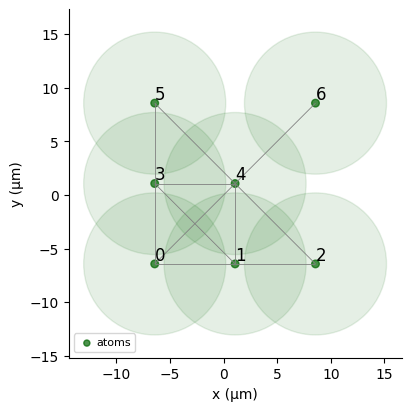

In [4]:
coords = coords - np.mean(coords, axis=0)
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

The above chosen value of $\Omega$ is only for graph visualization. Since we
need to implement a Pulse that will be used in the adiabatic evolution, we need to take into account the maximum value of $\Omega$ because the $R_b \propto 1/\Omega$. A smaller value of $\Omega$ implies a larger blockade radius and may create unwanted atomic interactions whereas a large $\Omega$ can result into loss of interactions.

To find the just right $\Omega$, we take the average of the maximum distance between connected nodes and the minimum distance between the not-connected nodes.

In [5]:
# basic omega calculation
link_max = np.sqrt(2)*step # diagonal of the square with side 'step'
no_link_min = 2*step # sum of 2 sides of the square

omega_min = Chadoq2.interaction_coeff / no_link_min ** 6
omega_max = Chadoq2.interaction_coeff / link_max ** 6
omega = (omega_min + omega_max)/2
omega

2.1412971970370367

## Quantum Adiabatic Algorithm

In [6]:
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

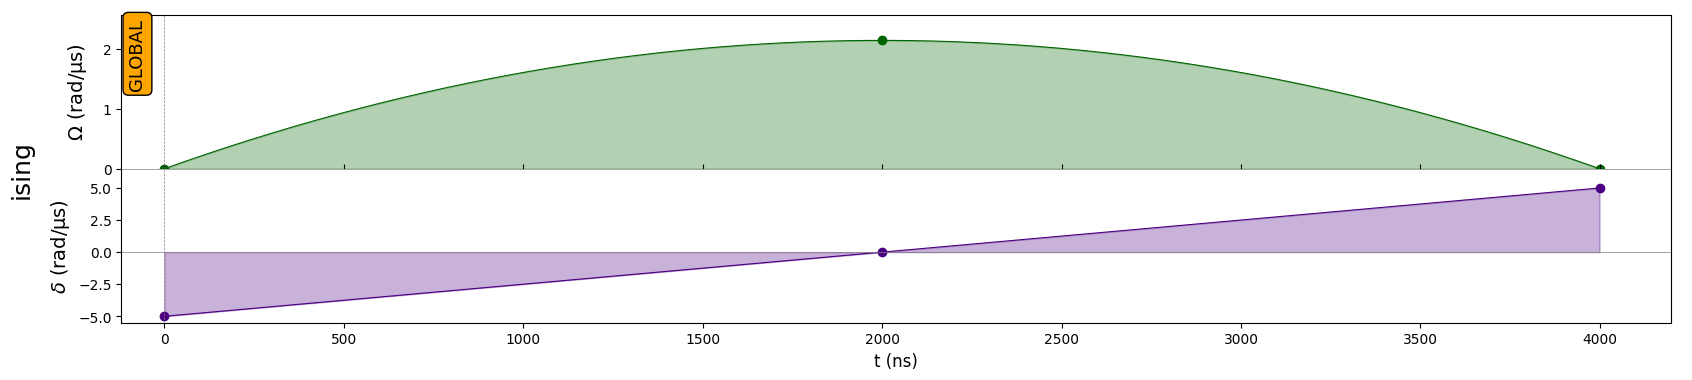

In [7]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [8]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run(num_cpus=12)
final = results.get_final_state()
count_dict = results.sample_final_state()

In [9]:
def plot_distribution(C, n_bars=10):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True)[:n_bars])
    indexes = ["1010011"]  # QUBO solutions
    color_dict = {key: "g" if key in indexes else "b" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.show()

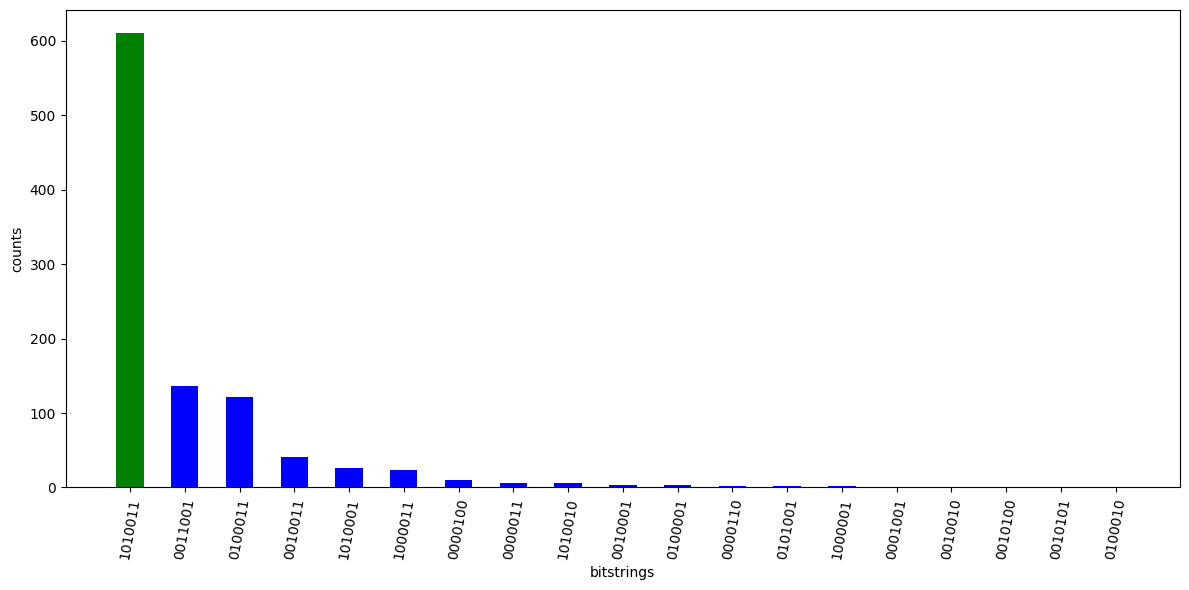

In [10]:
plot_distribution(count_dict, 20)

The bitstring with maximum counts is `1010011` which has 4 nodes in the independent set which are nodes `0, 2, 5 and 6` which is indeed the maximum independent set.

### Effect of different pulse duration on success probability

In [11]:
success_prob = []
for T in 1000 * np.linspace(1, 15, 15):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run(num_cpus=12)
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    success_prob.append(count_dict['1010011']/1000)

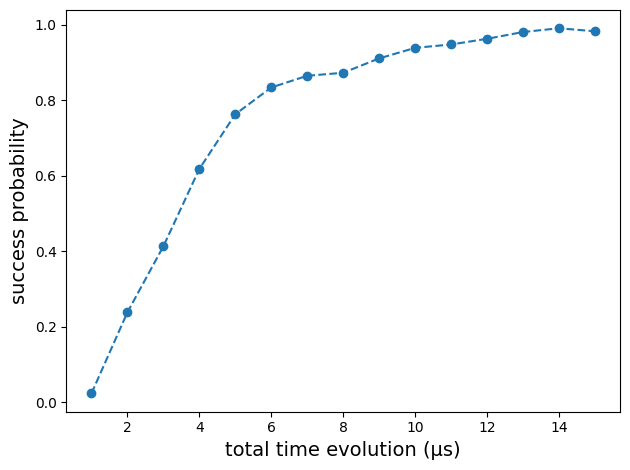

In [12]:
plt.plot(range(1, 16), success_prob, "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("success probability", fontsize=14)
plt.tight_layout()
plt.show()

## Quantum Approximation Optimization Algorithm

To ease the process and build the cost function, we need the adjacency matrix of the graph. For this we use the `KDTree` class from scipy to get the edges based on the position of the nodes and blockade radius.

In [13]:
from scipy.spatial import KDTree

epsilon = 1e-9  # Accounts for rounding errors
edges = KDTree(coords).query_pairs(Chadoq2.rydberg_blockade_radius(1.0) * (1 + epsilon))

G = nx.Graph()
G.add_edges_from(edges)

nodes = list(range(len(coords)))
adj = nx.adjacency_matrix(G, nodelist=nodes).todense()

In [14]:
LAYERS = 2 # Number of optimization cycles for QAOA

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

beta_list = seq.declare_variable("beta_list", size=LAYERS)
gamma_list = seq.declare_variable("gamma_list", size=LAYERS)

for beta, gamma in zip(beta_list, gamma_list):
    beta_pulse = Pulse.ConstantPulse(1000 * beta, 1.0, 0.0, 0)
    gamma_pulse = Pulse.ConstantPulse(1000 * gamma, 0.0, 1.0, 0)

    seq.add(beta_pulse, "ch0")
    seq.add(gamma_pulse, "ch0")

seq.measure("ground-rydberg")

In [15]:
guess = {
    "beta": np.random.uniform(1, 10, LAYERS),
    "gamma": np.random.uniform(1, 10, LAYERS),
}

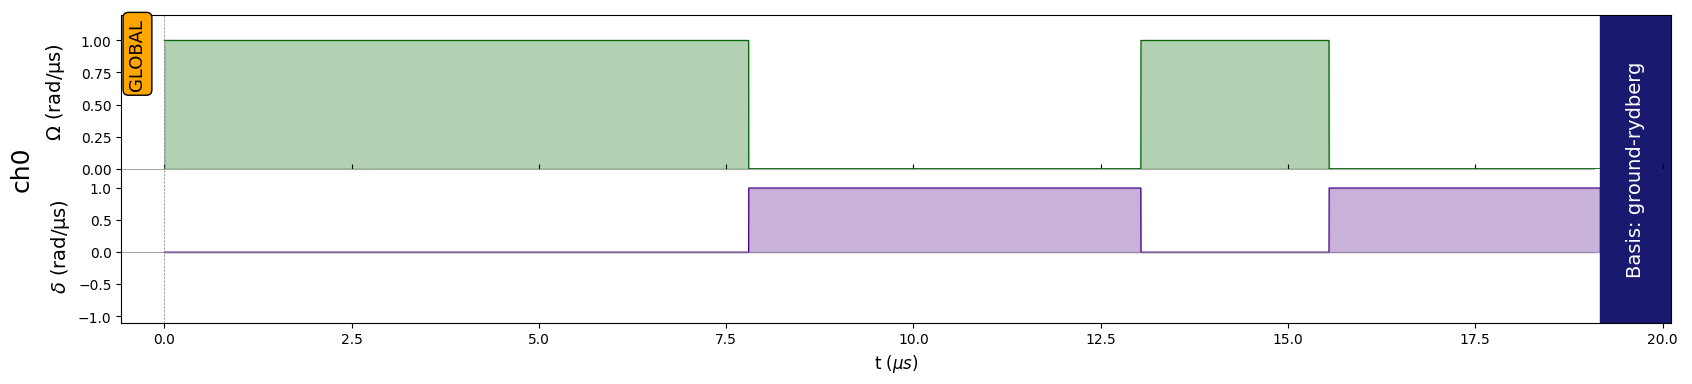

In [16]:
seq.build(beta_list=guess['beta'], gamma_list=guess['gamma']).draw()

The `get_cost` function implements the cost function (equation (1)). The `z` vector represents the nodes in the independent set and then the cost function ca be repsented as

$$ f(z) = -1^{T}z +  Uz^{T}Az $$

where A is the adjacency matrix. We take only the upper triangular matrix of A otherwise it will count the connections twice.

In [17]:
def quantum_loop(parameters):
    params = np.array(parameters) # betas and gammas
    beta_params, gamma_params = np.reshape(params.astype(int), (2, LAYERS))

    assigned_seq = seq.build(beta_list=beta_params, gamma_list=gamma_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)

    results = simul.run(num_cpus=12)
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

def get_cost(bitstring, A, U = 10):
    z = np.array(list(bitstring), dtype=int)
    cost = -np.sum(z) + U * (z.T @ A @ z)
    return cost

## weighted average cost over all the outputs obtained
def get_avg_cost(counts, A):
    cost = sum(counts[key] * get_cost(key, A) for key in counts)
    avg_cost = cost / sum(counts.values())  # Divide by total samples
    return avg_cost

# objective function
def func(param, *args):
    A = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, A)
    return cost

In [18]:
scores = []
params = []

for repetition in range(10):
    guess = {
        "beta": np.random.uniform(1, 10, LAYERS),
        "gamma": np.random.uniform(1, 10, LAYERS),
    }
    try:
        res = minimize(
            func,
            args=np.triu(adj),
            x0=np.r_[guess["beta"], guess["gamma"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 20},
        )
        scores.append(res.fun)
        params.append(res.x)

        print(f"Repetition: {repetition}, score: {res.fun}")
    except Exception as e:
        pass

Repetition: 1, score: -1.98
Repetition: 2, score: -1.319
Repetition: 3, score: -1.723
Repetition: 4, score: -1.616
Repetition: 5, score: -2.46
Repetition: 6, score: -1.261
Repetition: 7, score: -1.643
Repetition: 8, score: -1.86
Repetition: 9, score: -1.875


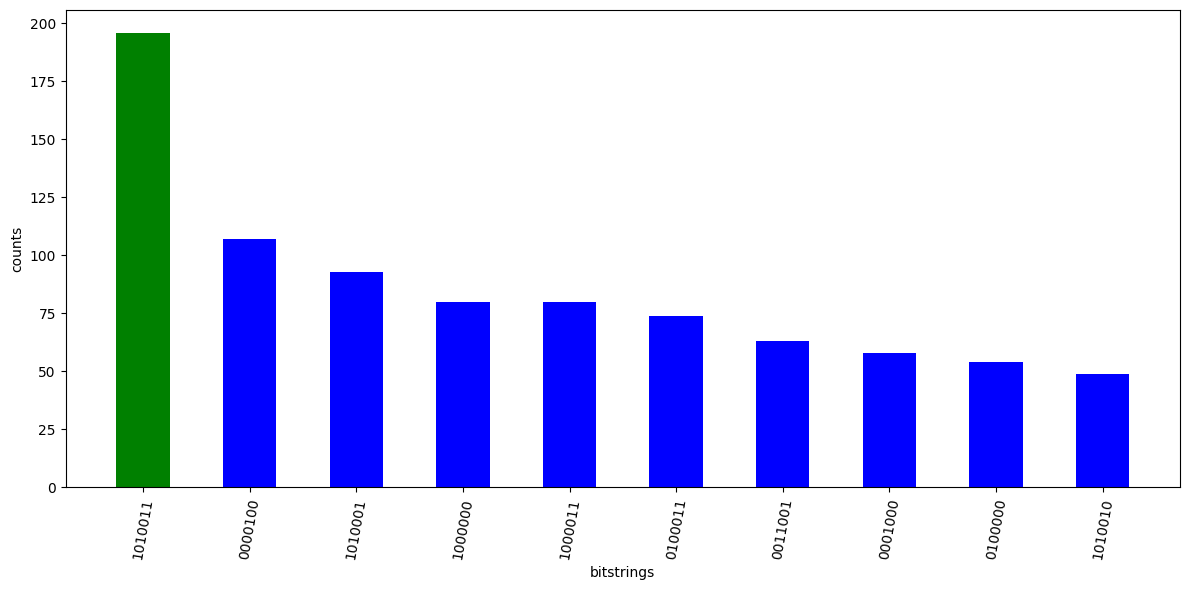

In [19]:
optimal_params = params[np.argmin(scores)]
optimal_count_dict = quantum_loop(optimal_params)
plot_distribution(optimal_count_dict)

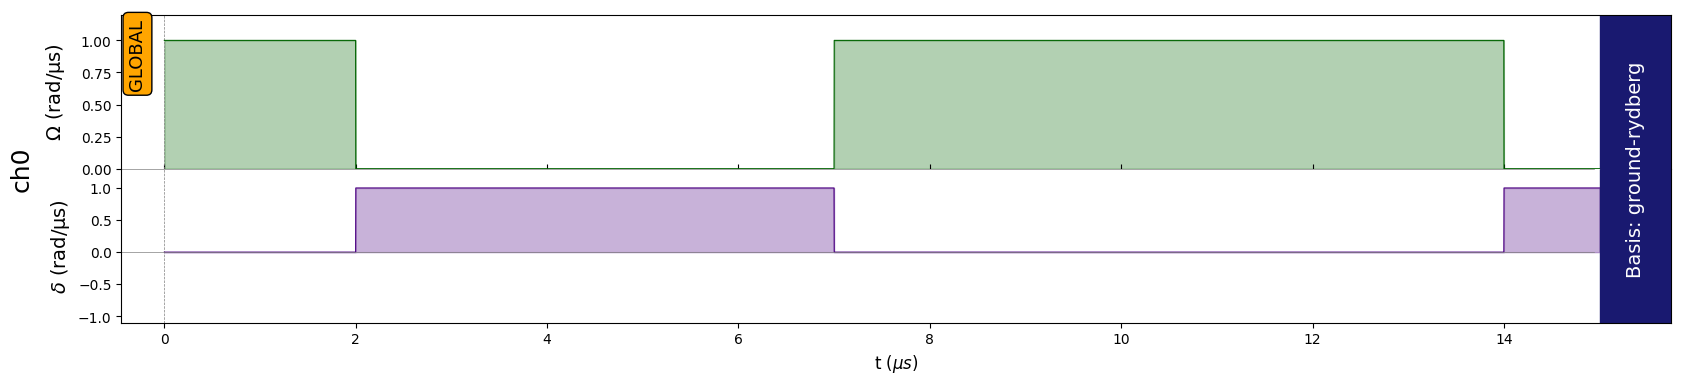

In [20]:
beta_params, gamma_params = np.reshape(optimal_params.astype(int), (2, LAYERS))
seq.build(beta_list=beta_params, gamma_list=gamma_params).draw()